In [2]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

Tree

In [3]:
class DecisionTree():
    def __init__(self, max_depth):
        self.label_encoder = LabelEncoder()
        self.best_feature = None
        self.depth = max_depth
        self.sub_trees = []
        self.feature_values = []
        self.n_class = 0

    def calculate_lables_portion(self, y_true : pd.DataFrame):
        Y = [0, 0]
        for i in range(y_true.size):
            Y[y_true[i]] += 1
        return Y, y_true.size

    def calculate_entropy(self, y_true):
        Y, N = self.calculate_lables_portion(y_true)
        H_Y = 0
        for y in Y:
            if y == 0:
                continue
            H_Y += -y/N * np.log2(y/N)
        return H_Y
    
    def calculate_mutual_info(self, H_Y, y_true, X_train, feature_name : str):
        H_Y_X = total_samples = 0
        values = X_train[feature_name].unique()

        for value in values:
            y_splitted = y_true[X_train[feature_name] == value]
            X_size = X_train[X_train[feature_name] == value][feature_name].count()
            total_samples += X_size
            H_Y_X = X_size * self.calculate_entropy(y_splitted)

        H_Y_X = H_Y_X / total_samples
        return H_Y - H_Y_X
    
    def find_best_feature(self, y_true : pd.DataFrame, X_train : pd.DataFrame):
        I = []
        I_features = dict()
        H_Y = self.calculate_entropy(y_true)
        for col in X_train.columns:
            H_Y_Xi = self.calculate_mutual_info(H_Y, y_true, X_train, col)
            I_features[H_Y_Xi] = col
            I.append(H_Y_Xi)

        I_max = np.max(I)
        best_feature = I_features[I_max]
        return best_feature

    def build(self, X_train : pd.DataFrame, y_train : pd.DataFrame):
        rows, _ = X_train.shape
        y_true = self.label_encoder.fit_transform(y_train)
        self.n_class = len(y_train.unique())
        if self.n_class == 1:
            self.result = y_true[0]
            # print(f"Leaf Depth: {self.depth}\tResult: {self.result}")
            return
        if self.depth == 0:
            class_counts = [0] * self.n_class
            for i in range(rows):
                class_counts[y_true[i]] += 1
            
            self.result = np.argmax(class_counts)
            # print(f"Leaf Depth: {self.depth}\tResult: {self.result}")
            return
        self.best_feature = self.find_best_feature(y_true, X_train)
        self.train_sub_tree(X_train, y_train)
    
    def train_sub_tree(self, X_train : pd.DataFrame, y_train : pd.DataFrame):
        values = X_train[self.best_feature].unique()
        for value in values:
            X_splitted = X_train[X_train[self.best_feature] == value]
            y_splitted = y_train[X_train[self.best_feature] == value]
            sub_tree = DecisionTree(max_depth=self.depth-1)
            X_splitted = X_splitted.drop(self.best_feature, axis=1)
            sub_tree.build(X_splitted, y_splitted)
            self.sub_trees.append(sub_tree)
            self.feature_values.append(value)

    def classify_result(self, X_test : pd.DataFrame, y_pred):
        if self.depth == 0 or self.best_feature == None:
            rows, _ = X_test.shape
            # print(f"Test Data size in Leaf : {rows}\tResult: {self.result}")
            y_pred[X_test.index] = int(self.result)
            return
        
        for i in range(len(self.feature_values)):
            X_splitted = X_test[X_test[self.best_feature] == self.feature_values[i]]
            rows, _ = X_splitted.shape
            self.sub_trees[i].classify_result(X_splitted, y_pred)

    def classify(self, X_test : pd.DataFrame):
        rows, _ = X_test.shape
        y_pred = pd.Series(np.zeros(rows))
        X_test = X_test.reset_index()
        self.classify_result(X_test, y_pred)
        return y_pred

Pre-processing Dataset

In [4]:
df = pd.read_csv('../Data/prison_dataset.csv', sep=',')
size_0 = df[df["Recidivism - Return to Prison numeric"] == 0]["Recidivism - Return to Prison numeric"].count()
for col in df.columns:
    labels, uniques = pd.factorize(df[col])
    df[col] = labels
df

,Fiscal Year Released,Recidivism Reporting Year,Race - Ethnicity,Age At Release,Convicting Offense Classification,Convicting Offense Type,Convicting Offense Subtype,Main Supervising District,Release Type,Part of Target Population,Recidivism - Return to Prison numeric
0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,1,0,1,0,0,0,0,0
2,0,0,0,0,0,1,0,1,0,0,0
3,0,0,0,1,1,2,1,0,0,0,0
4,0,0,1,0,0,2,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
15419,2,2,0,0,1,0,0,0,1,0,1
15420,2,2,0,0,0,1,0,1,1,1,1
15421,2,2,1,0,1,0,0,0,1,0,1
15422,2,2,0,0,0,2,0,1,0,1,1


Train Classifier

In [5]:
X = df.drop("Recidivism - Return to Prison numeric", axis=1)
y = df["Recidivism - Return to Prison numeric"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=17)

decision_tree = DecisionTree(max_depth=3)
decision_tree.build(X_train, y_train)

Test

The accuracy of the model is: %72.44732576985413


Text(113.9222222222222, 0.5, 'predicted label')

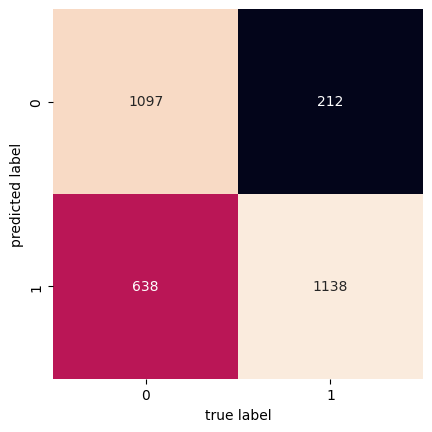

In [6]:
y_pred = decision_tree.classify(X_test)
print("The accuracy of the model is: %" + str(accuracy_score(y_test, y_pred)*100))

confusion_mtx = confusion_matrix(y_test, y_pred)

sns.heatmap(confusion_mtx.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label')